In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt

# Fertility Dataset

## Preprocessing

In [31]:
data_path = r'../Ex1/data/Fertility/fertility_diagnosis.csv'
df = pd.read_csv(data_path)
df = dpu.preprocess_fertility_dataset(df)

In [32]:
nn = NNFramework()
nn.fit_encoder(df=df, cols_to_encode=df.columns.difference(['age', 'hours_sitting']))
df_encoded = nn.encode_dataset(df)

## Parameter experiments

In [33]:
random_seed = 1038
scaling = True
oversampling = True

scaler = preprocessing.StandardScaler() if scaling else None

In [34]:
y = df_encoded['diagnosis']
X = df_encoded[df_encoded.columns.difference(['diagnosis'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)


In [35]:
activation_functions = ['relu', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_layer_sizes = [(5,), (32,), (16, 16), (10, 5, 5), (16, 8, 8), (64, 32, 32),]

In [36]:
methods = []

for af in activation_functions:
    for lr in learning_rates:
        for hls in hidden_layer_sizes:
            methods.append((f'MLP-{af}-{lr}-{hls}', MLP(n_iter=5000, activation_function=af, learning_rate=lr, hidden_layer_sizes=hls)))
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
cv_num = 5
model_params = {}
models = {}
models_lists = {}

for model_name, pipeline in pipelines.items():
    cv_results = cross_validate(pipeline, X, y, cv=cv_num, scoring='f1_macro', return_estimator=True, n_jobs=10)

    models[model_name] = cv_results['estimator']
    model_params[model_name] = {}
    models_lists[model_name] = {}

    num_cols = ['test_score', 'fit_time', 'score_time']

    for num_col in num_cols:
        models_lists[model_name][num_col] = cv_results[num_col]
        model_params[model_name][f'{num_col}_mean'] = cv_results[num_col].mean()
        model_params[model_name][f'{num_col}_std'] = cv_results[num_col].std()
    
    model_params[model_name]['parameter_num'] = cv_results['estimator'][0][model_name].number_of_params_
    model_params[model_name]['hidden_layer_sizes'] = cv_results['estimator'][0][model_name].hidden_layer_sizes
    model_params[model_name]['activation_function'] = cv_results['estimator'][0][model_name].activation_function
    model_params[model_name]['learning_rate'] = cv_results['estimator'][0][model_name].learning_rate
    models_lists[model_name]['converged'] = [e[model_name].converged_ for e in cv_results['estimator']]
    models_lists[model_name]['validation_losses'] = [e[model_name].validation_losses_ for e in cv_results['estimator']]
    models_lists[model_name]['training_losses'] = [e[model_name].training_losses_ for e in cv_results['estimator']]
    model_params[model_name]['num_iter'] = np.array(list([len(e[model_name].training_losses_) for e in cv_results['estimator']])).mean()

    print(model_name)
    print(
        f"f1 scores: {models_lists[model_name]['test_score']}\n" +
        f"f1 mean: {model_params[model_name]['test_score_mean']:.3f}\n" +
        f"f1 std: {model_params[model_name]['test_score_std']:.3f}\n"
    )
    print('----------------------------------------------------------------------------------------------------')
    

Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 75...
MLP-relu-0.0001-(5,)
f1 scores: [0.375      0.2        0.30666667 0.46666667 0.56709957]
f1 mean: 0.383
f1 std: 0.127

----------------------------------------------------------------------------------------------------
Loss did not go down for 10 iterations. Stopping training at iteration 30...
Loss did not go down for 10 iterations. Stopping training at iteration 10...
Loss did not go down for 10 iterations. Stopping training at iteration 45...
Loss did not go down for 10 iterations. Stopping training at iteration 30...
Loss did not go down for 10 iterations. Stopping training at iteration 519...
MLP-relu-

/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])


As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
MLP-relu-0.001-(64, 32, 32)
f1 scores: [0.09090909 0.09090909 0.47368421 0.42857143 0.13043478]
f1 mean: 0.243
f1 std: 0.171

----------------------------------------------------------------------------------------------------
Loss did not go down for 10 iterations. Stopping training at iteration 33...
Loss did not go down for 10 iterations. Stopping training at iteration 34...
Loss did not go down for 10 iterations. Stopping training at iteration 47...
Loss did not go down for 10 iterations. Stopping training at iteration 80...
Loss did not go down for 10 iterations. Stopping training at iteration 81...
MLP-relu-0.01-(5,)
f1 scores: [0.33333333 0.64157706 0.53125    0.56709957 0.42857143]
f1 mean: 0.500
f1 std: 0.108

----------------------------------------------------------------------------------------------------
Loss did not go down for 10 iter

/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])


Loss did not go down for 10 iterations. Stopping training at iteration 66...
MLP-relu-0.01-(10, 5, 5)
f1 scores: [0.29292929 0.6        0.6        0.44444444 0.44444444]
f1 mean: 0.476
f1 std: 0.115

----------------------------------------------------------------------------------------------------
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.


/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (

As a punishment we return a model with randomly initialized weights.
Loss did not go down for 10 iterations. Stopping training at iteration 51...
MLP-relu-0.01-(16, 8, 8)
f1 scores: [0.14786967 0.14786967 0.14786967 0.2481203  0.44444444]
f1 mean: 0.227
f1 std: 0.115

----------------------------------------------------------------------------------------------------
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
MLP-relu-0.01-(64, 32, 32)
f1 scores: [0.47368421 0.47368421 0.47368421 0.13043478 0.13043478]
f1 mean: 0.336
f1 std: 0.168

----------------------------------------------------------------------------------------------------
As a punishment we return a model with randomly initialized

/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (

Loss did not go down for 10 iterations. Stopping training at iteration 21...
MLP-relu-0.1-(5,)
f1 scores: [0.375      0.52380952 0.2        0.41176471 0.60784314]
f1 mean: 0.424
f1 std: 0.139

----------------------------------------------------------------------------------------------------
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
MLP-relu-0.1-(32,)
f1 scores: [0.375      0.6        0.48717949 0.65714286 0.37321937]
f1 mean: 0.499
f1 std: 0.115

----------------------------------------------------------------------------------------------------
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a 

/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (

As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
MLP-relu-0.1-(10, 5, 5)
f1 scores: [0.29292929 0.29292929 0.2481203  0.43734015 0.13043478]
f1 mean: 0.280
f1 std: 0.098

----------------------------------------------------------------------------------------------------
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
MLP-relu-0.1-(16, 8, 8)
f1 scores: [0.14786967 0.14786967 0.14786967 0.2481203  0.13043478]
f1 mean: 0.164
f1 std: 0.042

----------------------------------

/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: invalid value encountered in divide
  return (np.exp(X)/np.sum(np.exp(X), axis=1)[:, None])
/home/lexi/ML/ml_ss23_group13/Ex2/MLP.py:108: RuntimeWarning: overflow encountered in exp
  return (

As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
MLP-relu-0.5-(10, 5, 5)
f1 scores: [0.29292929 0.29292929 0.2481203  0.43734015 0.13043478]
f1 mean: 0.280
f1 std: 0.098

----------------------------------------------------------------------------------------------------
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
As a punishment we return a model with randomly initialized weights.
MLP-relu-0.5-(16, 8, 8)
f1 scores: [0.14786967 0.14786967 0.14786967 0.2481203  0.13043478]
f1 mean: 0.164
f1 std: 0.042

----------------------------------------------------------------------------------------------------
As

In [70]:
df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

# df_param.to_csv(r'results/fertility_params.csv', index=False)

In [123]:
modelsss = df_param.sort_values(['test_score_mean'], ascending=False).head(5)['model']
for mod in modelsss:
    pipelines[mod].fit(X_train, y_train)
    y_pred = pipelines[mod].predict(X_test)
    cu.eval(y_pred, y_test)

Loss did not go down for 10 iterations. Stopping training at iteration 57...
Evaluation metrics:


array([[0.94444444, 0.05555556],
       [1.        , 0.        ]])

acc: 0.85
balanced_acc: 0.4722222222222222

Macro-averaged precision: 0.4473684210526316
Macro-averaged recall: 0.4722222222222222
Macro-averaged f-score: 0.4594594594594595
Macro-averaged support: None
Loss did not go down for 10 iterations. Stopping training at iteration 181...
Evaluation metrics:


array([[0.5, 0.5],
       [1. , 0. ]])

acc: 0.45
balanced_acc: 0.25

Macro-averaged precision: 0.4090909090909091
Macro-averaged recall: 0.25
Macro-averaged f-score: 0.31034482758620685
Macro-averaged support: None
Loss did not go down for 10 iterations. Stopping training at iteration 308...
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None
Loss did not go down for 10 iterations. Stopping training at iteration 47...
Evaluation metrics:


array([[0.72222222, 0.27777778],
       [1.        , 0.        ]])

acc: 0.65
balanced_acc: 0.3611111111111111

Macro-averaged precision: 0.43333333333333335
Macro-averaged recall: 0.3611111111111111
Macro-averaged f-score: 0.39393939393939387
Macro-averaged support: None
Loss did not go down for 10 iterations. Stopping training at iteration 159...
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None


In [131]:
results_df = pd.DataFrame()
for mod in modelsss:
    y_pred = pipelines[mod].predict(X_test)
    eval_results = cu.eval(y_pred, y_test)

    results_df = results_df.append({
        'Model': mod,
        'cm': eval_results['cm'].flatten(),
        'acc': eval_results['acc'],
        'balanced_acc': eval_results['balanced_acc'],
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f-score': eval_results['f-score'],
        'support': eval_results['support']
    }, ignore_index=True)


Evaluation metrics:


array([[0.94444444, 0.05555556],
       [1.        , 0.        ]])

acc: 0.85
balanced_acc: 0.4722222222222222

Macro-averaged precision: 0.4473684210526316
Macro-averaged recall: 0.4722222222222222
Macro-averaged f-score: 0.4594594594594595
Macro-averaged support: None
Evaluation metrics:


array([[0.5, 0.5],
       [1. , 0. ]])

acc: 0.45
balanced_acc: 0.25

Macro-averaged precision: 0.4090909090909091
Macro-averaged recall: 0.25
Macro-averaged f-score: 0.31034482758620685
Macro-averaged support: None
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None
Evaluation metrics:


array([[0.72222222, 0.27777778],
       [1.        , 0.        ]])

acc: 0.65
balanced_acc: 0.3611111111111111

Macro-averaged precision: 0.43333333333333335
Macro-averaged recall: 0.3611111111111111
Macro-averaged f-score: 0.39393939393939387
Macro-averaged support: None
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None


In [133]:
results_df.to_csv("results/fertility_trainset.csv", index=False)

In [130]:
print(models_lists['MLP-sigmoid-0.01-(5,)']['test_score'])
print(models_lists['MLP-sigmoid-0.0001-(16, 16)']['test_score'])
print(models_lists['MLP-relu-0.01-(32,)']['test_score'])

[0.31034483 0.65714286 0.60784314 0.53125    0.60784314]
[0.41176471 0.65714286 1.         0.28571429 0.52      ]
[0.375      0.60784314 0.60784314 0.42857143 0.60784314]


In [79]:
def get_losses(df, loss_col = 'validation_losses', from_str = False):
    model_names = df.model.tolist()
    validation_losses = df[loss_col].tolist()

    models_vl = {}
    for vl, model_name in zip(validation_losses, model_names):
        models_vl[model_name] = {}
        if from_str:
            vl = vl.split('], [')
        for i, vl_cv in enumerate(vl):
            if from_str:
                vl_cv = [float(s) for s in vl_cv.replace('[', '').replace(']', '').split(', ')]
            models_vl[model_name][i] = vl_cv
    
    return models_vl

In [80]:
vl_losses_dict = get_losses(df_param)
tl_losses_dict = get_losses(df_param, loss_col='training_losses')

KeyError: 'validation_losses'

In [81]:
model_name = 'MLP-sigmoid-0.1-(5,)'
i = 0
plot_data = {
    'vls': vl_losses_dict[model_name][i],
    'tls': tl_losses_dict[model_name][i]
}
plot_data = pd.DataFrame(plot_data)
plot_data = plot_data.reset_index(drop=False)
plot_data = plot_data.melt(id_vars='index', value_vars=['vls', 'tls'])
plot_data.columns = ['iteration', 'loss_type', 'loss']

ValueError: If using all scalar values, you must pass an index

In [62]:
y_key = 'vls'
sns.lineplot(data=plot_data, x='iteration', y='loss', hue='loss_type')

ValueError: Could not interpret value `iteration` for parameter `x`

In [54]:
df_param = pd.read_csv(r'results/fertility_params.csv')

In [55]:
converged = df_param['converged'].values.tolist()
converged_new = []
for cs in converged:
    cs = cs.replace('[', '').replace(']', '').split(', ')
    c_bools = [c == 'True' for c in cs]
    converged_new.append(c_bools)
df_param['converged'] = converged_new

In [56]:
df_param['converged_final'] = df_param.converged.apply(lambda x: all(x))

In [57]:
df_param.columns

Index(['model', 'test_score', 'test_score_mean', 'test_score_std', 'fit_time',
       'fit_time_mean', 'fit_time_std', 'score_time', 'score_time_mean',
       'score_time_std', 'parameter_num', 'hidden_layer_sizes',
       'activation_function', 'learning_rate', 'converged',
       'validation_losses', 'training_losses', 'num_iter', 'converged_final'],
      dtype='object')

ValueError: `errorbar` must be a callable, string, or (string, number) tuple

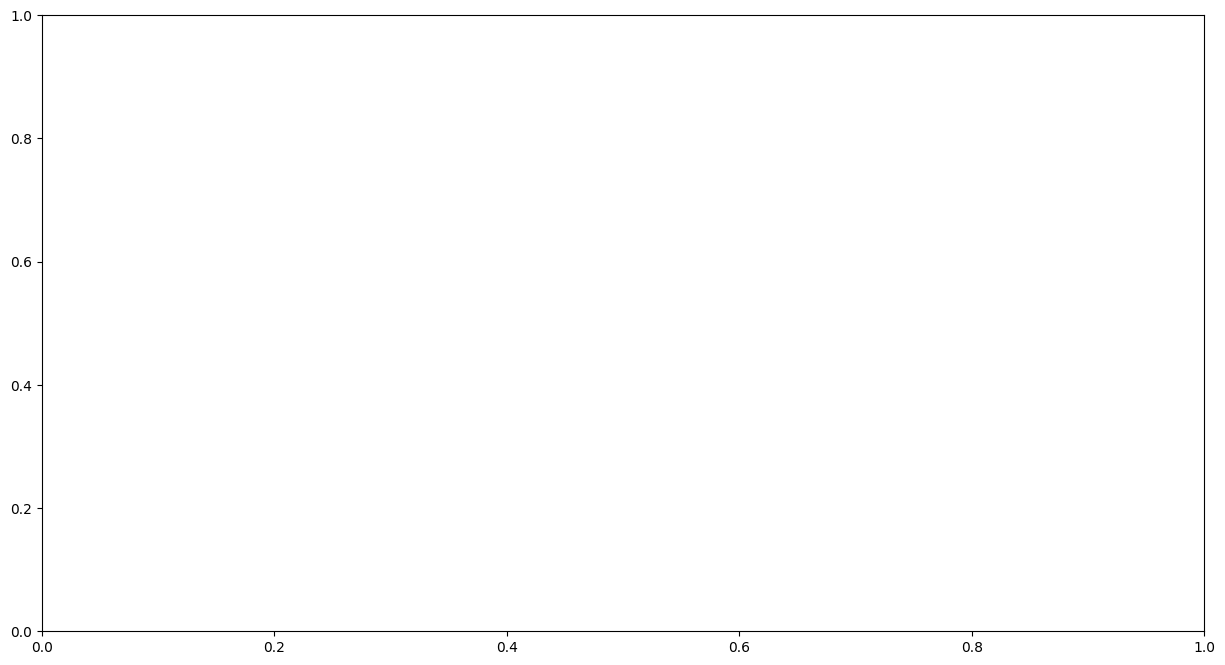

In [58]:
_, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=df_param[df_param.converged_final], y='model', x='fit_time_mean', hue='activation_function', ax=ax, errorbar=())
ax.set_title('Mean fitting times over converged models')


## Comparison 